In [330]:
import pandas as pd
import numpy as np
import torch
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader


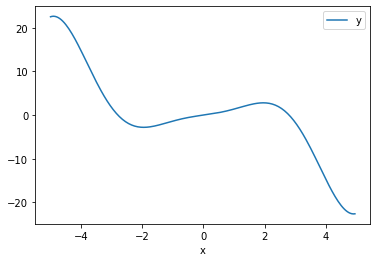

In [331]:
# We start by reading the data
df = pd.read_csv('../Data/data.txt', names = ['x','y'])

# Plotting the data
df.plot(x='x', y='y')
plt.show()

In [346]:
# Splitting data into 90/10 train/test datasets.
x_train, x_test, y_train, y_test = train_test_split(df.x, df.y, test_size=0.10, random_state=99)
df_train, df_test = train_test_split(df, test_size=0.20, random_state=99)

# Reshapes data from list of elements to list of lists, i.e. from (160) to (160,1).
reshaper = lambda x: [[element] for element in x ]
# Unshapes the data. Needed to be able to plot the data later.
unshaper = lambda x: [ elements[0] for elements in x ]

# Reshape and cast data to float tensor, needed for pytorch functions.
X_train = torch.FloatTensor(reshaper(x_train.values))
X_test = torch.FloatTensor(reshaper(x_test.values))
Y_train = torch.FloatTensor(reshaper(y_train.values))
Y_test = torch.FloatTensor(reshaper(y_test.values))

In [347]:
# Create a dataset object in a certain format for the dataloader to work.
class dds(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return len(self.x)

In [349]:
# Init Dataset object that we created, and also a dataloader that split our data into batches. 
# I set batch_size = 1 to only train the network for one observation at a time.
datasetObject = dds(X_train, Y_train)
train_loader = DataLoader(dataset = datasetObject, batch_size = 1)

In [350]:
# Creating the feed forward neural network architecture.
class FeedForward(torch.nn.Module):
        # Defining our init function for the feedforward class.
        def __init__(self, n_inputs, n_outputs, hidden_size):
            # Initializing the Feedforward class from pytorch nn module.
            super(FeedForward, self).__init__()
            self.inputs = n_inputs
            self.outputs  = n_outputs
            self.hidden = hidden_size
            
            # Defining the layers
            self.fc1 = torch.nn.Linear(self.inputs, self.hidden)
            self.fc2 = torch.nn.Linear(self.hidden, self.hidden)
            self.fc3 = torch.nn.Linear(self.hidden, self.hidden)
            self.fc4 = torch.nn.Linear(self.hidden, self.outputs)
            
            # Defining the actication functions
            self.relu = torch.nn.ReLU()
            self.sigmoid = torch.nn.Sigmoid()
            
            # Initialize weights
            #self.init_weights()
        
        def init_weights(self):
            torch.nn.init.normal_(self.fc1.weight)
            torch.nn.init.normal_(self.fc2.weight)
            torch.nn.init.normal_(self.fc3.weight)
            torch.nn.init.normal_(self.fc4.weight)
            
        def forward(self, features):
            output = self.fc1(features)
            output = self.relu(output)
            output = self.fc2(output)
            output = self.relu(output)
            output = self.fc3(output)
            output = self.relu(output)
            output = self.fc4(output)
            return output

In [342]:
# Create a network object.
model = FeedForward(n_inputs = X_train.shape[1], n_outputs = 1, hidden_size = 150)


# Create a loss criteria and optimizer.
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.0001)

In [343]:
# Train the network
epochs = 30
valid_losses = []
train_losses = []

for epoch in range(epochs):
    for features, targets in train_loader:
        # Forward propagation
        output = model.forward(features)
        # Calculate the loss
        loss = criterion(output, targets)
        # Initialize the gradient to zero
        optimizer.zero_grad()
        # Back propagation
        loss.backward()
        # Update the weights
        optimizer.step()
        
    # Stop the training
    model.eval() 
    
    # Save the losses
    train_loss = criterion(model(X_train), Y_train).item()
    valid_loss = criterion(model(X_test), Y_test).item()
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f"train loss: {train_loss}, val loss: {valid_loss}")
    
    model.train()


train loss: 49.08131408691406, val loss: 54.05958938598633
train loss: 40.52974319458008, val loss: 42.66053771972656
train loss: 38.72821807861328, val loss: 40.12411880493164
train loss: 36.47431564331055, val loss: 37.103939056396484
train loss: 33.63872146606445, val loss: 33.52106475830078
train loss: 30.49724578857422, val loss: 29.47494125366211
train loss: 26.64354705810547, val loss: 24.769834518432617
train loss: 22.16554832458496, val loss: 19.66465950012207
train loss: 17.474666595458984, val loss: 14.801058769226074
train loss: 13.43523120880127, val loss: 10.964789390563965
train loss: 10.275805473327637, val loss: 8.21223258972168
train loss: 8.02238941192627, val loss: 6.332610130310059
train loss: 6.4823784828186035, val loss: 4.997381210327148
train loss: 5.374789237976074, val loss: 3.9924442768096924
train loss: 4.535210132598877, val loss: 3.226968288421631
train loss: 3.9066271781921387, val loss: 2.6443419456481934
train loss: 3.4110686779022217, val loss: 2.1868

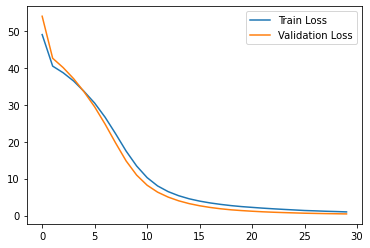

In [344]:
# Plot training loss and  validation loss for each epoch

x = range(len(train_losses))

plt.plot(x, train_losses, label = "Train Loss")
plt.plot(x, valid_losses, label = "Validation Loss")
plt.legend()
plt.show()

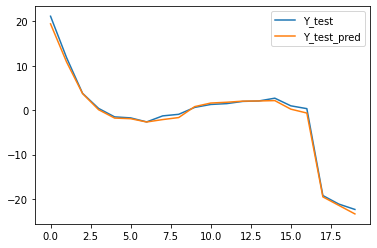

In [345]:
Y_test_pred = unshaper(model(X_test).detach().numpy())
results = pd.DataFrame({'x':unshaper(X_test.numpy()), 'y_test':unshaper(Y_test.numpy()), 'y_test_pred':Y_test_pred}).sort_values('x')
training_data = pd.DataFrame({'x':unshaper(X_train.numpy()), 'y_train':unshaper(Y_train.numpy())}).sort_values('x')


plt.plot(range(len(X_test)), results['y_test'], label="Y_test")
plt.plot(range(len(X_test)), results['y_test_pred'],label= "Y_test_pred")
#plt.plot(range(len(X_train)), training_data['y_train'], label="Y_train")
plt.legend()
plt.show()

[]

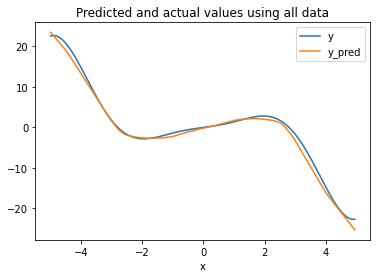

In [368]:
Y_pred = model(torch.FloatTensor(torch.FloatTensor(reshaper(df['x'].values))))
Y_pred = unshaper(Y_pred.detach().numpy())
df['y_pred'] = Y_pred
df.plot(x = 'x', title="Predicted and actual values using all data")
plt.plot()